<a href="https://colab.research.google.com/github/athayasyaqra/Bangkit_ML/blob/main/In_Care_Out_Care_Classification_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.11


In [ ]:
# Installing rectified adam

!pip install keras-rectified-adam
from keras_radam import RAdam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-py3-none-any.whl size=9017 sha256=dc8e10877258579e86c8c947fc8325e267135a7004bfa305c3b50c5e574759a3
  Stored in directory: /root/.cache/pip/wheels/52/1d/66/374c85b327ea412af5301b4811088408d9764314d6cfb8f127
Successfully built keras-rectified-adam


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
import pickle

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

# for styling
plt.style.use('seaborn-whitegrid')

# **Data Exploration**
**Upload the data**



In [ ]:
data = pd.read_csv('/content/data-ori.csv')
data.head(10)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out
5,34.3,11.6,4.53,6.6,185,25.6,33.8,75.7,1,M,out
6,31.1,8.7,5.06,11.1,416,17.2,28.0,61.5,1,F,out
7,40.3,13.3,4.73,8.1,257,28.1,33.0,85.2,1,F,out
8,33.6,11.5,4.54,11.4,262,25.3,34.2,74.0,1,F,out
9,35.4,11.4,4.80,2.6,183,23.8,32.2,73.8,1,F,out


**Feature exploration**

In [ ]:
# Checking features
print(f"Dataset mengandung {data.shape[0]} baris dan {data.shape[1]} kolom")

num_features = [feat for feat in data if data[feat].dtype != object]
cat_features = [feat for feat in data if data[feat].dtype == object]

print(f"Jumlah fitur : {len(num_features+cat_features)}")
print(f"Jumlah fitur numerik : {len(num_features)}")
print(f"Jumlah fitur kategori : {len(cat_features)}\n")

Dataset mengandung 4412 baris dan 11 kolom
Jumlah fitur : 11
Jumlah fitur numerik : 9
Jumlah fitur kategori : 2



In [ ]:
data[num_features].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


In [ ]:
# Checking empty data
data.isnull().sum().sort_values(ascending=False)

SOURCE          0
SEX             0
AGE             0
MCV             0
MCHC            0
MCH             0
THROMBOCYTE     0
LEUCOCYTE       0
ERYTHROCYTE     0
HAEMOGLOBINS    0
HAEMATOCRIT     0
dtype: int64

In [ ]:
# # Checking outliers in data
# def find_outliers(x):
#   q1 = np.percentile(x,25)
#   q3 = np.percentile(x,75)
#   iqr = q3-q1
#   floor = q1 - 1.5*iqr
#   ceiling = q3 + 1.5*iqr
#   outliers_indices = list(x.index[(x < floor)|(x > ceiling)])
#   outliers_values = list(x[outliers_indices])

#   return outliers_indices, outliers_values

# data_ex = data.drop('SOURCE', axis=1)

# for (columnName, columnData) in (data_ex.iteritems()):
#   outliers_indices, outliers_values = find_outliers(data[columnName])
#   print(columnName)
#   print(np.sort(outliers_values))

In [ ]:
print(n)

#**Preprocessing Data**

In [ ]:
def preprocess(df):
    df = df.copy()
    
    # Binary encoding 
    df['SEX'] = [0 if x == 'F' else 1 for x in df['SEX']]
    df['SOURCE'] = [1 if x == 'out' else 0 for x in df['SOURCE']]
    #df['SEX']= df.SEX.replace({'F':0,'M':1}, inplace=True)
    #df['SOURCE']= df.SOURCE.replace({'out':0,'in':1}, inplace=True) 

    # Dividing data
    y = df['SOURCE']
    X = df.drop('SOURCE', axis=1)

    # Checking numbers of the data 
    print(X.value_counts())
    print(y.value_counts())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=42)
    
    # Scaling data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns) 
    
    # # Normalizing data
    # normalizer = Normalizer().fit(X_train)
    # X_train = pd.DataFrame(normalizer.transform(X_train), index=X_train.index, columns=X_train.columns)
    # X_test = pd.DataFrame(normalizer.transform(X_test), index=X_test.index, columns=X_test.columns)  

    # # Scaling data using maxminscaler
    # scaler = MinMaxScaler(feature_range=(0,1))
    # scaler.fit(X_train)
    # X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    # X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns) 

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess(data)

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE  MCH   MCHC  MCV   AGE  SEX
69.0         12.1          4.04         6.2        307          30.0  34.8  86.1  69   1      1
36.1         11.9          4.77         4.9        317          24.9  33.0  75.7  3    1      1
             11.7          4.81         5.5        400          24.3  32.4  75.1  82   0      1
             11.8          3.93         5.2        235          30.0  32.7  91.9  52   0      1
                           4.26         3.1        151          27.7  32.7  84.7  37   0      1
                                                                                             ..
41.1         13.7          4.95         3.8        204          27.7  33.3  83.0  25   0      1
             13.6          5.06         15.9       418          26.9  33.1  81.2  68   0      1
                           5.01         2.8        131          27.1  33.1  82.0  29   0      1
                           4.96         6.6  

In [ ]:
y_train.value_counts()
# for y in y_train:
#   if y == 1:
#     print('true')
#   print('false')

1    1575
0    1072
Name: SOURCE, dtype: int64

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2647, 10)
(1765, 10)


In [ ]:
# # Dropping less correlated features 
# X_train.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)
# X_test.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)

In [ ]:
print(X_train.head(5))

      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  ...       MCV       AGE       SEX
230     -0.653976     -0.169187    -0.042465  ... -1.234352 -1.748236  0.953119
1832     0.580147      0.643500     0.316166  ...  0.358083 -0.270071  0.953119
2117     1.180531      0.978136     1.059044  ... -0.032787 -0.039108  0.953119
2474    -1.137619     -0.742849    -0.798152  ... -0.655285  0.238048  0.953119
472      1.981043      1.886433     2.083704  ... -0.496041 -1.332502  0.953119

[5 rows x 10 columns]


#**Define and Training the Model**

In [ ]:
# Define baseline model
def model_baseline():
  model = Sequential()
  model.add(Dense(10, input_dim=10, activation='linear'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# Hyperparameter tuning using GridSearch
optimizers = ['adam', 'RAdam']
epoches = [50, 100, 150]
batches = [2, 3, 5]
learn_rate = [0.31, 0.33, 0.35, 0.37]
momentum = [1.2, 1.23, 1.25, 1.27]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
parameter_grid = dict(activation=activation)

# model = KerasClassifier(build_fn=model_baseline, verbose=2)
# grid = GridSearchCV(estimator=model, param_grid=parameter_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train,y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# # Data training using pipeline
# estimators = []
# #estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn=model_baseline, epochs=150, batch_size=2, verbose=2)))
# pipeline = Pipeline(estimators)
# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
# print('\n')
# print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# Checkpoint definition
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Fitting model to data
model = model_baseline()
history = model.fit(X_train, y_train, validation_split=0.33, epochs=150, batch_size=2, callbacks=callbacks_list, verbose=2)

# # Fitting model to data
# pipeline.fit(X_train, y_train)

# # Predicting data
# y_pred = pipeline.predict(X_test)

Epoch 1/150
887/887 - 16s - loss: 0.6930 - accuracy: 0.6345 - val_loss: 0.6207 - val_accuracy: 0.6636

Epoch 00001: val_accuracy improved from -inf to 0.66362, saving model to weights-improvement-01-0.66.hdf5
Epoch 2/150
887/887 - 2s - loss: 0.6055 - accuracy: 0.7050 - val_loss: 0.5848 - val_accuracy: 0.7162

Epoch 00002: val_accuracy improved from 0.66362 to 0.71625, saving model to weights-improvement-02-0.72.hdf5
Epoch 3/150
887/887 - 2s - loss: 0.5671 - accuracy: 0.7293 - val_loss: 0.5651 - val_accuracy: 0.7151

Epoch 00003: val_accuracy did not improve from 0.71625
Epoch 4/150
887/887 - 2s - loss: 0.5532 - accuracy: 0.7394 - val_loss: 0.5617 - val_accuracy: 0.7174

Epoch 00004: val_accuracy improved from 0.71625 to 0.71739, saving model to weights-improvement-04-0.72.hdf5
Epoch 5/150
887/887 - 2s - loss: 0.5527 - accuracy: 0.7310 - val_loss: 0.5654 - val_accuracy: 0.7140

Epoch 00005: val_accuracy did not improve from 0.71739
Epoch 6/150
887/887 - 2s - loss: 0.5480 - accuracy: 0.7

In [ ]:
# Convert the model
final_model = tf.keras.models.load_model('/content/weights-improvement-46-0.73.hdf5')
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

# Save the model to tflite
with open('final_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmptl3anh30/assets


#**Evaluating Performance of the Model**

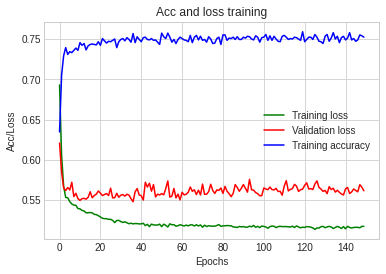

In [ ]:
# Graph visualization
loss_train = history.history['loss']
loss_val = history.history['val_loss']
acc_train = history.history['accuracy']
epochs = range(0,150)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.title('Acc and loss training')
plt.xlabel('Epochs')
plt.ylabel('Acc/Loss')
plt.legend()
plt.show()

In [ ]:
# Defining evaluation matrix
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

Recall:  0.7525773195876289
Accuracy:  0.7365439093484419
Precision:  0.8319088319088319
F1:  0.7902571041948578


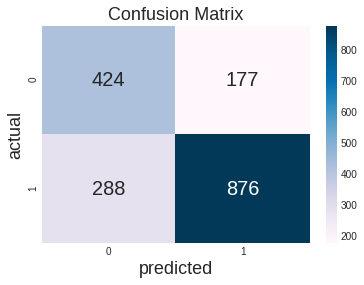

In [ ]:
# Predicting based on trained model
y_predicted = model.predict_classes(X_test)
evaluation(y_predicted, y_test)

In [ ]:
# Testing
# hm = 34.5 # HAEMATOCRIT
# hb = 12.5 # HAEMOGLOBINS
# er = 4.17 # ERYTHROCYTE
# leu = 15.3 # LEUCOCYTE
# tro = 122 # THROMBOCYTE
# mch = 27.6 # MCH
# mchc = 33.3 # MCHC 
# mcv = 82.7 # MCV
# age = 66 # AGE
# sex = 1 # SEX

# hm = 35.1 # HAEMATOCRIT
# hb = 11.8 # HAEMOGLOBINS
# er = 4.65 # ERYTHROCYTE
# leu = 6.3 # LEUCOCYTE
# tro = 310 # THROMBOCYTE
# mch = 25.4 # MCH
# mchc = 33.6 # MCHC 
# mcv = 75.5 # MCV
# age = 1 # AGE
# sex = 0 # SEX

#pred_incare = [[34.5 , 12.5 , 4.17 , 15.3 , 122 , 27.6 , 33.3 , 82.7 , 66 , 1]]
pred_outcare = [[35.1 , 11.8 , 4.65 , 6.3 , 310 , 25.4 , 33.6 , 75.5 , 1 , 0]]
pred_incare = [[31.7 , 10.4 , 4.91 , 9.7 , 348 , 21.2 , 32.8 , 64.6 , 21 , 1]]
rawat_inap = [[40.0 , 15.0 , 4.0 , 8.0 , 300 , 24.0 , 33.0 , 90.0 , 21 , 1]]
uploaded_model = tf.keras.models.load_model('/content/weights-improvement-29-0.74.hdf5')
prediction_DL = model.predict_classes(rawat_inap)

#score1 = model.score(X_test, y_test)
print(prediction_DL[0][0])
if prediction_DL[0][0] == 1:
    pred = "out care patient"
else:
    pred = "in care patient"
print('Prediksi :',pred)
#print("Test score: {0:.2f} %".format(100 * score1))  